In [23]:
import sys 
sys.path.append('..')

from models import DIFDensityEstimator,SoftmaxWeightOver,LocationScaleFlow
from models import EMDensityEstimator
from targets import Target, Uniform
%load_ext autoreload
%autoreload 2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


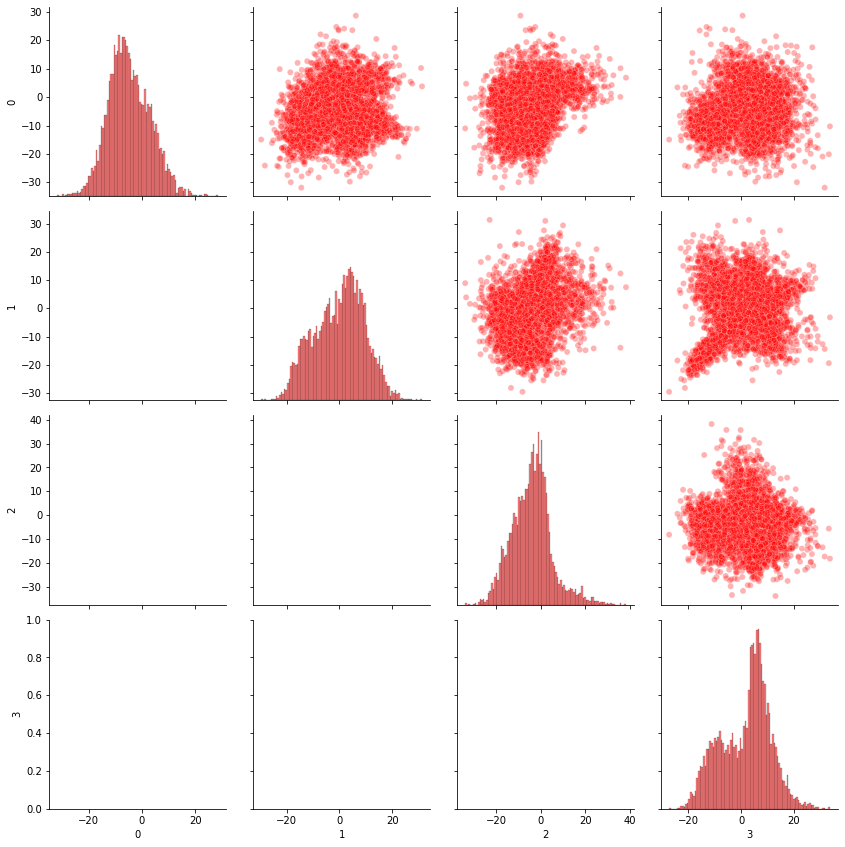

In [24]:
example = "Multimodal Dimension 4"
num_samples = 10000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 266.26it/s, loss = 13.46729850769043]


tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


C:\Users\Elouan\PycharmProjects\Discretely-Indexed-Flows\venv\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

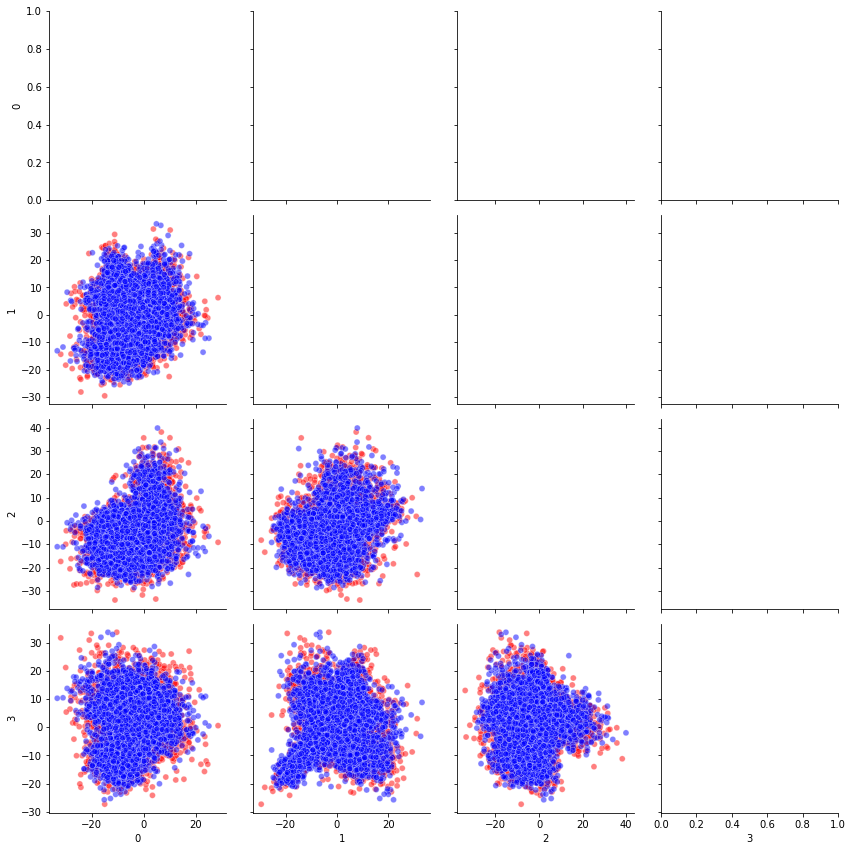

In [25]:
num_samples = target_samples.shape[0]
epochs = 50
K = 20
EM = EMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs,visual=False)
EM.model_visual()
print(-torch.mean(EM.log_density(target_samples.to(torch.device('cuda')))))

In [11]:
print(EM.log_pi)

Parameter containing:
tensor([-4.0326, -3.7050, -2.5103, -3.3745, -2.7296, -3.7041, -3.3249, -3.1078,
        -2.7812, -7.6009, -3.2345, -2.3982, -2.6335, -2.4916, -3.1449, -3.8371,
        -2.6715, -2.5432, -3.4696, -2.5158], device='cuda:0',
       requires_grad=True)


  0%|                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s, loss = 195.11805725097656]

tensor(195.1700, device='cuda:0', grad_fn=<NegBackward0>)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.51it/s, loss = 194.8547821044922]


ValueError: cannot reindex from a duplicate axis

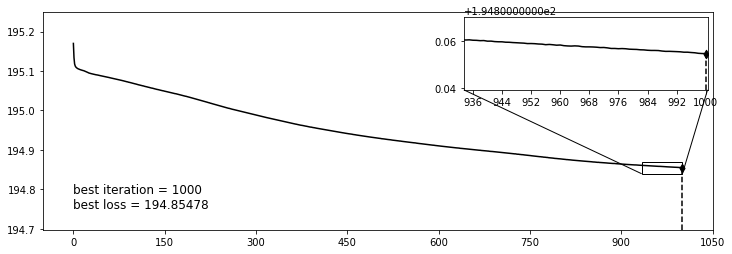

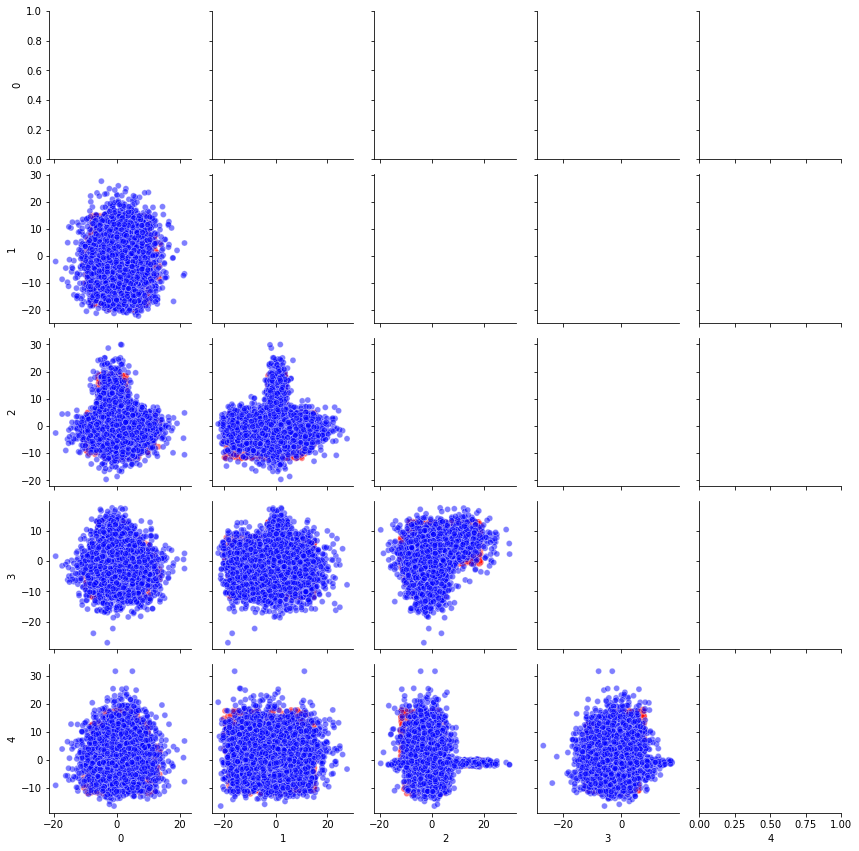

In [14]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 1000
batch_size = 500
K = 20
initial_T = EM.T.to(torch.device('cuda'))
initial_w = SoftmaxWeightOver(K, p, [], mode = 'Linear').to(torch.device('cuda'))
initial_w.log_b = nn.Parameter(EM.log_pi.to(torch.device('cuda')))
initial_w.a = nn.Parameter(torch.zeros(K,p).to(torch.device('cuda')))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
print(dif.loss(target_samples.to(torch.device('cuda')), mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

  1%|█▋                                                                                                                                                                         | 1/100 [00:00<00:10,  9.29it/s, loss = 196.2475128173828]

tensor(196.2865, device='cuda:0', grad_fn=<NegBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s, loss = 193.31793212890625]


ValueError: cannot reindex from a duplicate axis

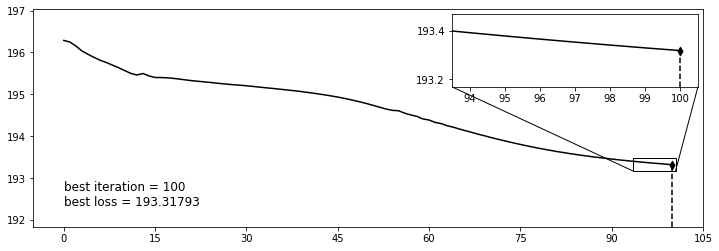

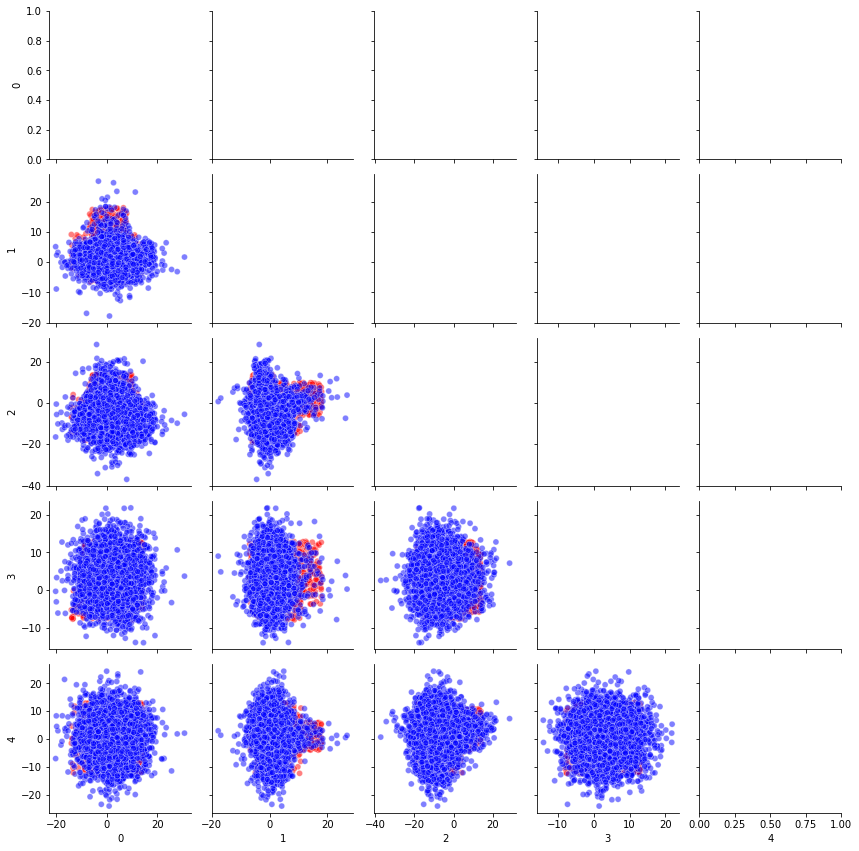

In [16]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = num_samples
K = 20
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, p, [256,256,256], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 256))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.a = nn.Parameter(torch.zeros(K,p))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
print(dif.loss(target_samples.to(torch.device('cuda')), mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [59]:
z = torch.randn(1000,p)
print(torch.mean(torch.exp(dif.w.log_prob(z)), dim = 0))

tensor([0.0107, 0.0517, 0.0616, 0.0751, 0.0037, 0.0745, 0.0149, 0.0597, 0.0427,
        0.0791, 0.0546, 0.0142, 0.0093, 0.0812, 0.0863, 0.0087, 0.0584, 0.0676,
        0.0411, 0.1048], grad_fn=<MeanBackward1>)


  0%|                                                                                                                                                             | 0/500 [00:00<?, ?it/s]

tensor(2151.0247, grad_fn=<NegBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:55<00:00,  1.41it/s, loss = 218.95291137695312]


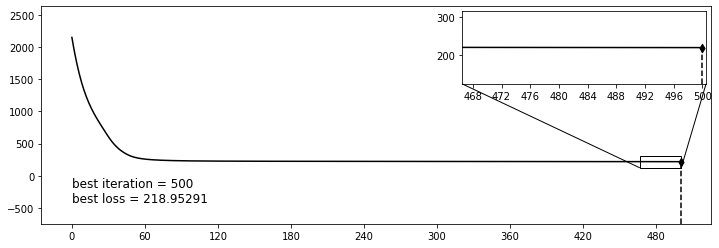

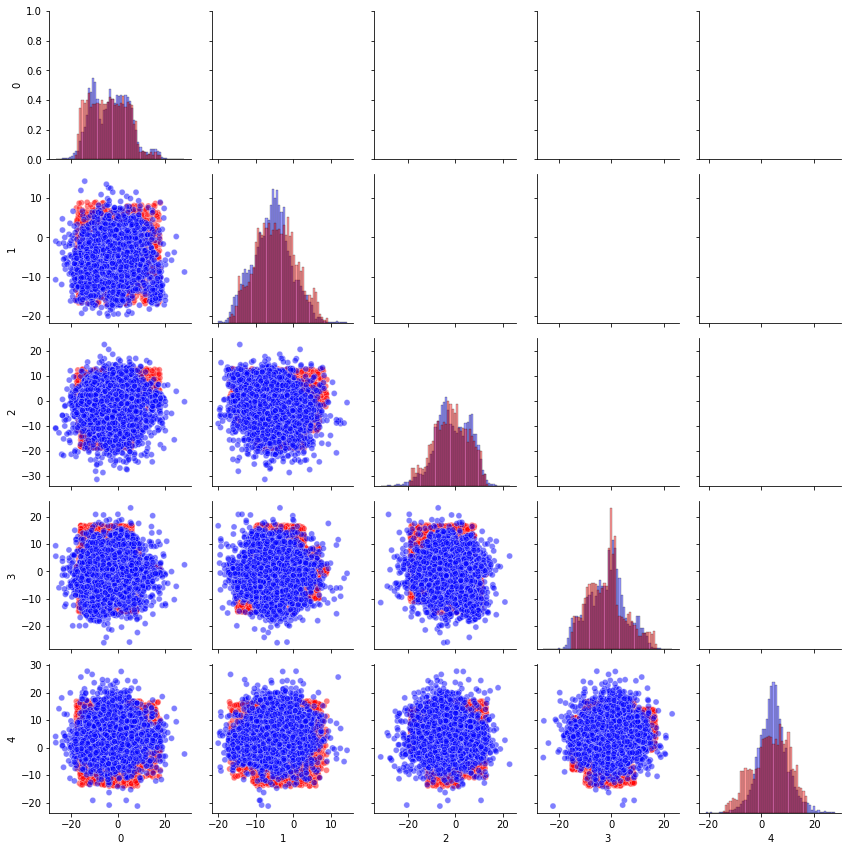

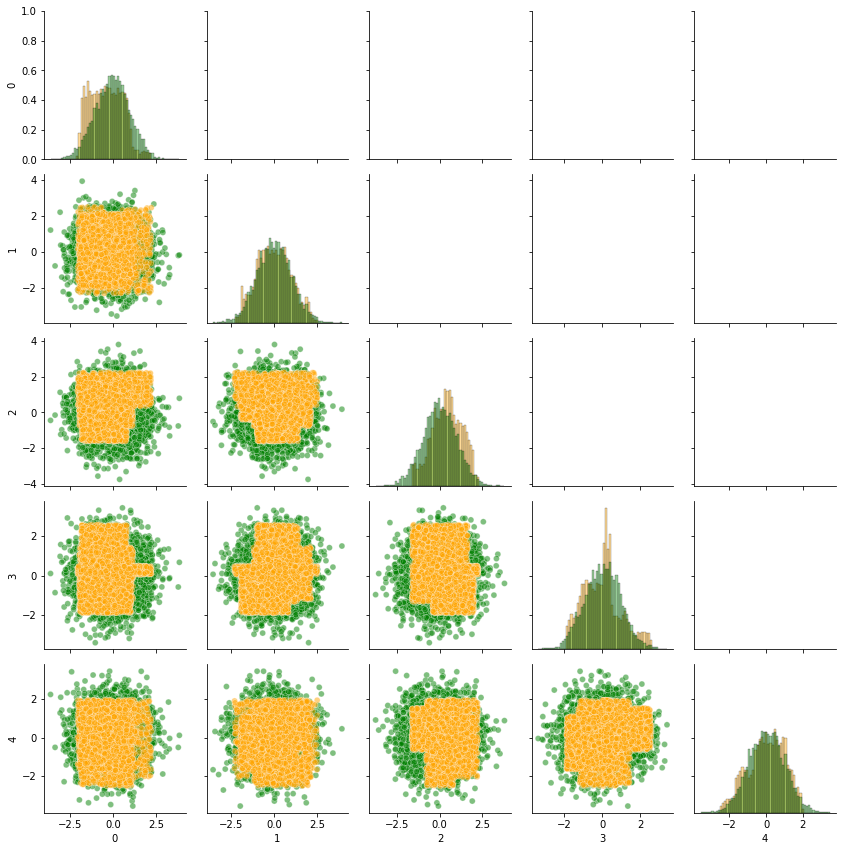

In [64]:
epochs = 500
batch_size = int(num_samples/5)
dif = DIFDensityEstimator(target_samples,K, initial_w = Softmax)
print(dif.loss(target_samples, mode ='SGD'))
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [65]:
z = torch.randn(1000,p)
print(torch.mean(torch.exp(dif.w.log_prob(z)), dim = 0))

tensor([0.0012, 0.0202, 0.0337, 0.0264, 0.0250, 0.0474, 0.0220, 0.0264, 0.0292,
        0.0114, 0.0652, 0.0393, 0.0236, 0.0267, 0.0895, 0.0275, 0.0233, 0.3701,
        0.0474, 0.0447], grad_fn=<MeanBackward1>)


In [17]:
print(penguins)

    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2     

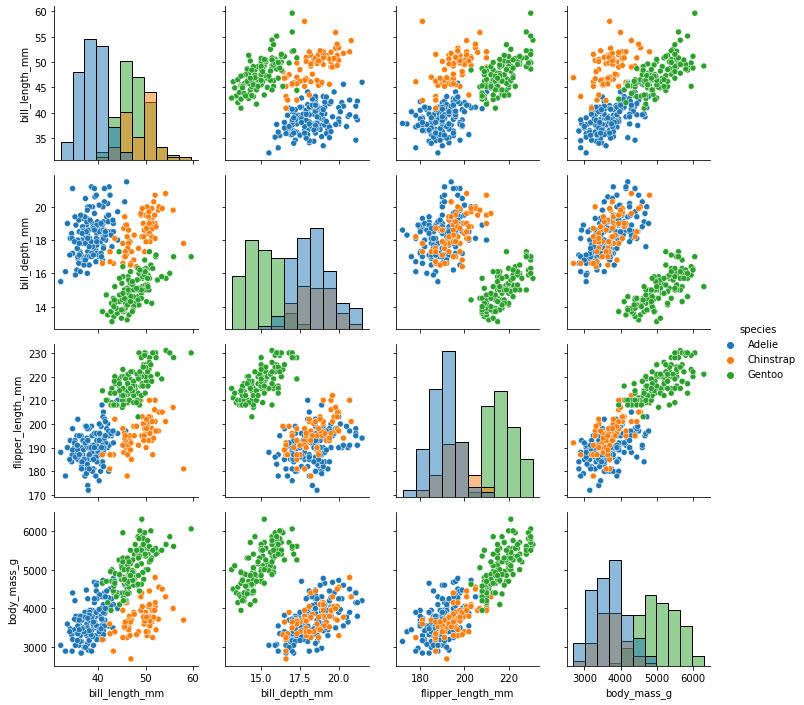

In [16]:
g = sns.PairGrid(penguins, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()